In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from torch.nn.functional import normalize
from scipy.optimize import curve_fit
import inspect
from functools import partial,wraps,reduce
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
def _normalize(t):
    return t/t.norm()
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(0)

In [2]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_tensor,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry
from utils import show_matrix,show_tensor_ijkl,show_tensor_ikjl

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

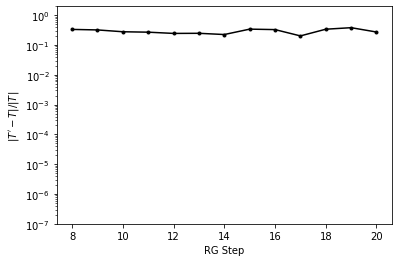

  0%|          | 0/21 [00:00<?, ?it/s]

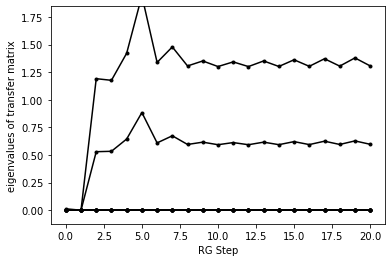

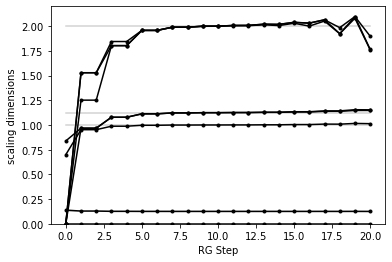

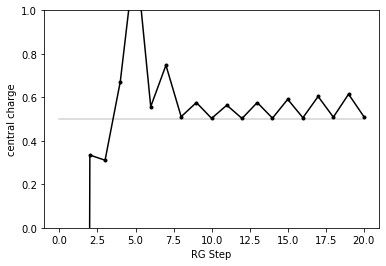

In [4]:
data=pd.DataFrame()
options={
    'nLayers':20,
    'max_dim':40,
    'gilt_enabled':False,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    #'gilt_record_S':True,
    'mcf_enabled':True,
    #'mcf_enabled_unitary':True,
    'mcf_eps':1e-16,
    'mcf_max_iter':200,
    #'hotrg_sanity_check':True,
    #'hotrg_sanity_check_tol':1e-7,
}

#params=AKLT2D.get_default_params()
#params['a2']=2.86522
#model=AKLT2D(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(2),model.get_ST0(2)

#params=AKLT2DStrange.get_default_params()
#params['a2']=4
#model=AKLT2DStrange(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(0)+model.get_ST0(1),model.get_ST0(0)-model.get_ST0(1)

params=Ising2D.get_default_params()
params['beta']+=0
model=Ising2D(params)
T0=model.get_T0()

reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

layers,Ts,logTotals=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        options=options,
                        return_tensors=True)

show_diff(Ts,stride=2)
#show_diff(fix_gauge.fix_gauges1(Ts,is_HOTRG=True),stride=2)
#show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)
#show_asymmetry(Ts)

In [5]:

def mysvd(M,k=10,tol=0,maxiter=500):
    dim=M.shape[1]
    k=min(k,min(M.shape))
    eigvecs,eigvals=[],[]
    tols=tol if isinstance(tol,list) else [tol]*k
    maxiters=maxiter if isinstance(maxiter,list) else [maxiter]*k
    pbar1=tqdm(range(k),leave=False)
    for j in pbar1:
        v=np.random.randn(dim);v=v/np.linalg.norm(v)
        with tqdm(range(maxiters[j]),leave=False) as pbar:
            for i in pbar:
                vn=M.rmatvec(M.matvec(v).conj()).conj()
                for u in eigvecs:
                    vn=vn-u*(u.conj()@vn)
                if np.linalg.norm(vn)==0:
                    raise ValueError
                eig=np.linalg.norm(vn)/np.linalg.norm(v)
                vn=vn/np.linalg.norm(vn)
                err=np.linalg.norm(vn-v)
                v=vn
                pbar1.set_postfix(eig=eig,err=err)
                if err<=tols[j]:
                    pbar.close()
                    break
        
        if err>tols[j]:
            print('Not Converged! err=',err)
        eigvecs.append(v)
        eigvals.append(eig)
    u=np.array([v/np.linalg.norm(v) for v in [M*v for v in eigvecs]]).T
    s=np.array(eigvals)**.5
    vh=np.array(eigvecs).conj()
    return u,s,vh



#M=np.random.randn(5,4)
#u,s,vh=mysvd(scipy.sparse.linalg.aslinearoperator(M))
#print(np.linalg.norm(u@np.diag(s)@vh-M))

In [9]:
from HOTRGZ2 import forward_layer
from functorch import jvp,vjp
from math import prod
import scipy.sparse.linalg
from scipy.sparse.linalg import eigs,eigsh,svds,LinearOperator,aslinearoperator

def get_linearized_HOTRG_autodiff(T0,layers):
    dimT=prod(T0.shape)
    x0=T0.reshape(-1)
    pbar=tqdm()
    print(f'dimension: {dimT}x{dimT}')
    def forward_layers(v):
        #print('foo')
        v=v.reshape(T0.shape)
        for layer in layers:
            v=forward_layer(v,v,layer)
        #print(v.shape)
        return v.reshape(dimT)
    def matvec(x):
        x=torch.tensor(x)
        _,y=jvp(forward_layers,primals=(T0.reshape(-1),),tangents=(x,))
        y=y.detach().cpu().numpy()
        pbar.update(1)
        return y
    def rmatvec(x):
        x=torch.tensor(x)
        _, vjpfunc=vjp(forward_layers,T0.reshape(-1))
        y=vjpfunc(x)[0]
        y=y.detach().cpu().numpy()
        pbar.update(1)
        return y
    return LinearOperator(shape=(dimT,dimT),matvec=matvec,rmatvec=rmatvec)

def get_linearized_HOTRG(T0,layers):
    dimT=prod(T0.shape)
    pbar=tqdm()
    def forward_layers(v):
        T,Y=T0,v.reshape(T0.shape)
        for layer in layers:
            T1=forward_layer(T,T,layer)
            Y1=forward_layer(T+Y,T,layer)-T1
            Y2=forward_layer(T,T+Y,layer)-T1
            T,Y=T1,Y1+Y2
        #print(T.norm(),T0.norm())
        Y*=T0.norm()/T.norm()
        return Y.reshape(-1)
    def operator(v):
        pbar.update(1)
        return forward_layers(torch.tensor(v)).detach().cpu().numpy()
    return LinearOperator(shape=(dimT,dimT),matvec=operator)



iLayer=18
norms=list(map(HOTRGZ2.gauge_invariant_norm,Ts))
T=Ts[iLayer]
T=ScalingDimensions.fix_normalize(T,is_HOTRG=True,norms=norms[:iLayer+1])

#sref=ScalingDimensions.get_transfer_matrix_spectrum_2D(T,loop_length=3)[1]


#M=get_op()

_,sr,vhr=mysvd(get_linearized_HOTRG_autodiff(T,layers[iLayer:iLayer+2]),k=16,tol=[1e-15]*3+[1e-10]*16,maxiter=200)
sr,ur=torch.tensor(sr),torch.tensor(vhr).T.conj()
        
#ncv=30
#maxiter=min(M.shape[0]*10,np.iinfo(np.int32).max)
#s,v=eigsh(M, k=5, which='LM',maxiter=maxiter,ncv=ncv)
#print(s)

print(options)
print('scaling dimensions from linearized TRG')
print(ScalingDimensions.get_scaling_dimensions(sr,scaling=2))
print('central charge from linearized TRG')
print(ScalingDimensions.get_central_charge(sr,scaling=2))

0it [00:00, ?it/s]

dimension: 2560000x2560000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.0007463540649154582


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.0004310492487930999


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 1.6928189589428124e-08


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 1.631079603286757e-07


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.003752517753621284


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.0001485765347120895


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 1.370185337651184e-06


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 1.5153047971610949e-05


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.0030118530617614008


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.0014005128888637322


  0%|          | 0/200 [00:00<?, ?it/s]

Not Converged! err= 0.005568223051063853
{'nLayers': 20, 'max_dim': 40, 'gilt_enabled': False, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': True, 'mcf_eps': 1e-16, 'mcf_max_iter': 200}
scaling dimensions from linearized TRG
tensor([-0.0000, 0.1280, 0.9074, 1.0637, 1.0627, 1.6286, 1.6444, 1.6968, 1.7444,
        1.7471, 1.7474, 1.7932, 1.8770, 1.9094, 1.9100, 1.9167])
central charge from linearized TRG
tensor(29.2449)


In [10]:
torch.save((params,options,Ts,layers),'linearized_tensors_40.pkl')
torch.save((iLayer,sr,ur),'linearized_eigen_40.pkl')

In [478]:

def get_linearized_cylinder(T0):
    dimT=prod(T0.shape)
    pbar=tqdm()
    def evolve(v):
        v=v.reshape(T0.shape)
        return contract('iIab,jJbc,kKcd,lLda,IJKL->ijkl',T0,T0,T0,T0,v).reshape(-1)
    def operator(v):
        pbar.update(1)
        return evolve(torch.tensor(v)).detach().cpu().numpy()
    return LinearOperator(shape=(dimT,dimT),matvec=operator)

sc,uc=myeig(get_linearized_cylinder(T),tol=1e-8,k=10,maxiter=20)
#sc,uc=myeig(get_linearized_cylinder(T),tol=1e-8,k=10,maxiter=200)

print('scaling dimensions from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_scaling_dimensions(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))
print('central charge from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_central_charge(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [533]:
print(options)
print('scaling dimensions from linearized TRG')
print(ScalingDimensions.get_scaling_dimensions((sr),scaling=2))
print('central charge from linearized TRG')
print(ScalingDimensions.get_central_charge((sr),scaling=2))
print('scaling dimensions from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_scaling_dimensions((sc),scaling=np.exp(2*np.pi/4)))
print('central charge from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_central_charge((sc),scaling=np.exp(2*np.pi/4)))

{'nLayers': 30, 'max_dim': 12, 'gilt_enabled': True, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': True, 'mcf_eps': 1e-16, 'mcf_max_iter': 20}
scaling dimensions from linearized TRG
tensor([-0.0000, 0.1420, 0.8764, 1.0207, 1.0198, 1.5695, 1.5726, 1.6353, 1.6541,
        1.6557, 1.6618, 1.6641, 1.7245, 1.7532, 1.7804, 1.7841])
central charge from linearized TRG
tensor(26.8671)
scaling dimensions from Transfer Matrix on a Cylinder


TypeError: log(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [568]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_tensor,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry
from utils import show_matrix,show_tensor_ijkl,show_tensor_ikjl

In [11]:
def show_perturbation_tensor(T_op,u,labels=None,title='', project_out=[],ax=None):
    lT=(T_op.reshape(-1))
    b=lT@u
    for v in project_out:
        bv=_normalize(v.reshape(-1)@u)
        b=b-(b@bv)*bv
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()

In [12]:
T0_op=model.get_SZT0()
checkerboard=False
labels=[f'{d:.3f}' for d in ScalingDimensions.get_scaling_dimensions(sr,scaling=2)]
def NPT(*positions):
    T,T_op,logTotal=forward_observable_tensors(T0,[T0_op]*len(positions),positions,\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
    return T_op
def proj(T,out=[]):
    b=T.reshape(-1)@ur
    for v in out:
        bv=v.reshape(-1)@ur;bv/=bv.norm()
        b=b-(b@bv)*bv
    return b
def hist(b,title='',ax=None):
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

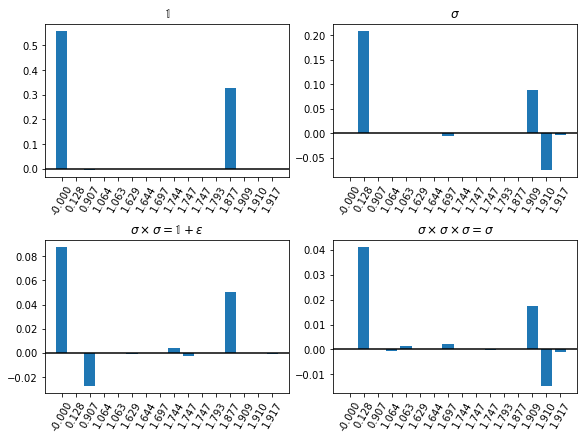

In [13]:
fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(8,6))

T_id=NPT()
hist(proj(T_id),title=r'$\mathbb{1}$',ax=axes[0,0])

m,m1=511,512
T_1pt=NPT((m,m))#+NPT((m,m1))+NPT((m1,m))+NPT((m1,m1))
hist(proj(T_1pt),title=r'$\sigma$',ax=axes[0,1])

m=511
l,r=511-200,512+200
T_2pt=NPT((l,m),(r,m))
hist(proj(T_2pt),title=r'$\sigma \times \sigma=\mathbb{1}+\epsilon$',ax=axes[1,0])

T_3pt=NPT((511-100,511-173),
          (511-100,511+173),
          (511+200,511))
hist(proj(T_3pt),title=r'$\sigma \times \sigma \times \sigma=\sigma$',ax=axes[1,1])
plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

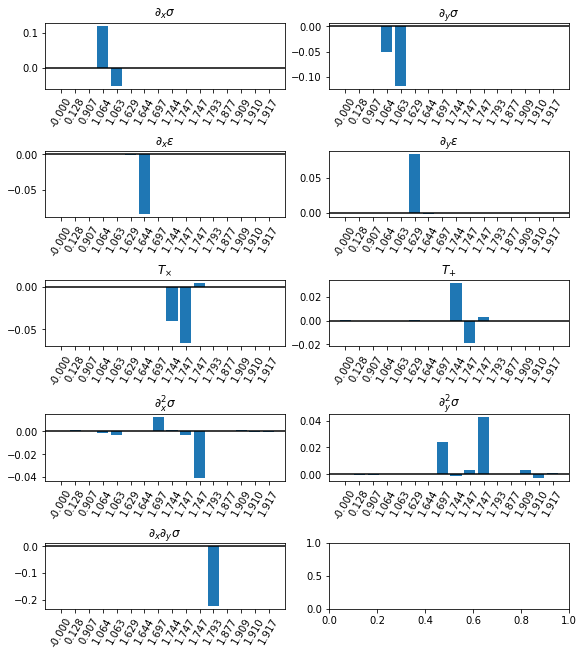

In [14]:



m,m1=511,512
l,r=0+100,1023-100
l1,r1=511-100,512+100

T_dsdx=NPT((r,m))-NPT((l,m))
T_dsdy=NPT((m,r))-NPT((m,l))


T_dedx=NPT((r,l),(r,r))-NPT((l,l),(l,r))
T_dedy=NPT((l,r),(r,r))-NPT((l,l),(r,l))


T_T=NPT((l,l),(r,r))-NPT((l,r),(r,l))
T_T1=NPT((l,m),(r,m))-NPT((m,l),(m,r))
#T_Tbar=T_T

a,b,c,d=NPT((l,m)),NPT((l1,m)),NPT((r1,m)),NPT((r,m))
T_dsdx2=a-b-c+d

a,b,c,d=NPT((m,l)),NPT((m,l1)),NPT((m,r1)),NPT((m,r))
T_dsdy2=a-b-c+d

a,b,c,d=NPT((l,l)),NPT((l,r)),NPT((r,l)),NPT((r,r))
T_dsdxdy=a-b-c+d


fig, axes = plt.subplots(5,2, constrained_layout=True,figsize=(8,9))
hist(proj(T_dsdx),title=r'$\partial_x \sigma$',ax=axes[0,0])
hist(proj(T_dsdy),title=r'$\partial_y \sigma$',ax=axes[0,1])
hist(proj(T_dedx),title=r'$\partial_x \epsilon$',ax=axes[1,0])
hist(proj(T_dedy),title=r'$\partial_y \epsilon$',ax=axes[1,1])
hist(proj(T_T),title=r'$T_{\times}$',ax=axes[2,0])
hist(proj(T_T1),title=r'$T_{+}$',ax=axes[2,1])
hist(proj(T_dsdx2),title=r'$\partial_x^2 \sigma$',ax=axes[3,0])
hist(proj(T_dsdy2),title=r'$\partial_y^2 \sigma$',ax=axes[3,1])
hist(proj(T_dsdxdy),title=r'$\partial_x\partial_y \sigma$',ax=axes[4,0])
plt.show()


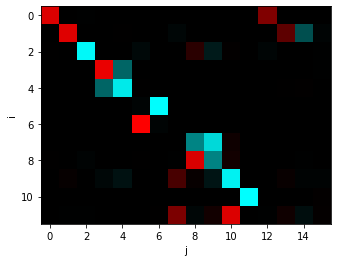

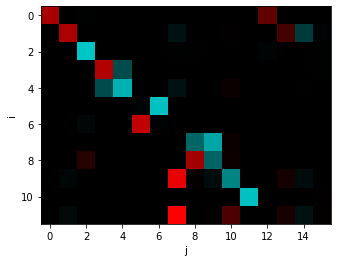

In [15]:
#def screen(b,rows):
#    b=b.clone()
#    for i in range(len(b)):
#        if i not in rows:
#            b[i]=0
#    return b
#Mdot=torch.stack([
#    screen(proj(T_id),[0]),
#    screen(proj(T_1pt),[1]),
#    screen(proj(T_2pt,out=[T_id]),[2]),
#    screen(proj(T_dsdx),[3,4]),
#    screen(proj(T_dsdy),[3,4]),
#    screen(proj(T_dedx),[5,6]),
#    screen(proj(T_dedy),[5,6]),
#    screen(proj(T_T), [9,10]),
#    screen(proj(T_T1),[9,10]),
#    screen(proj(T_dsdx2),  [7,8,11]),
#    screen(proj(T_dsdxdy), [7,8,11]),
#    screen(proj(T_dsdy2),  [7,8,11]),
#])
Mdot=torch.stack([
    proj(T_id),
    proj(T_1pt),
    proj(T_2pt,out=[T_id]),
    proj(T_dsdx),
    proj(T_dsdy),
    proj(T_dedx),
    proj(T_dedy),
    proj(T_T), 
    proj(T_T1),
    proj(T_dsdx2),  
    proj(T_dsdxdy), 
    proj(T_dsdy2),  
])
for i in range(Mdot.shape[0]):
    Mdot[i]/=Mdot[i].norm()
    
    
#Mrot=torch.zeros_like(Mdot)
#Mrot[0,0]=1/Mdot[0,0]
#Mrot[1,1]=1/Mdot[1,1]
#Mrot[2,2]=1/Mdot[2,2]
#Mrot[3:5,3:5]=torch.linalg.inv(Mdot[3:5,3:5]).T
#Mrot[5:7,5:7]=torch.linalg.inv(Mdot[5:7,5:7]).T
#Mrot[7:10,7:12]=torch.linalg.pinv(Mdot[7:10,7:12]).T
Mrot=torch.linalg.pinv(Mdot).T

show_matrix(Mdot.cpu());plt.show()
show_matrix(Mrot.cpu());plt.show()

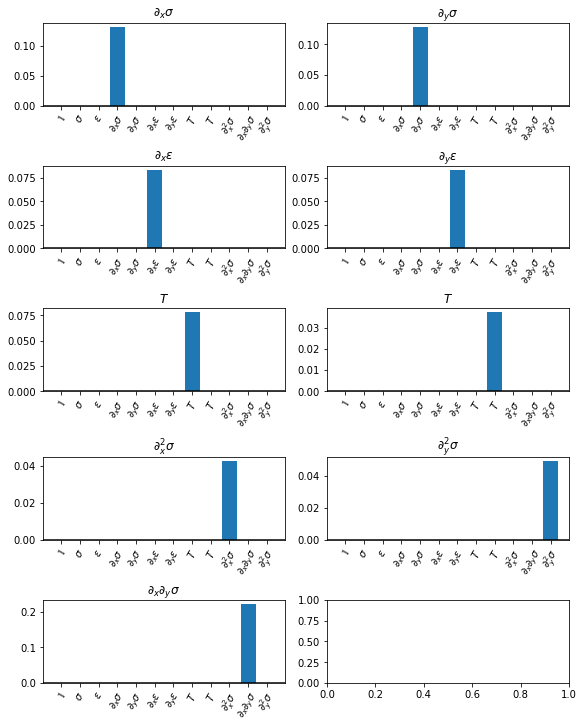

In [16]:
labels1=[
    r'$\mathbb{1}$',
    r'$\sigma$',
    r'$\epsilon$',
    r'$\partial_x \sigma$',
    r'$\partial_y \sigma$',
    r'$\partial_x \epsilon$',
    r'$\partial_y \epsilon$',
    r'$T$',
    r'$T$',
    r'$\partial_x^2 \sigma$',
    r'$\partial_x\partial_y \sigma$',
    r'$\partial_y^2 \sigma$',
]
def hist1(b,title='',ax=None):
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels1)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()
        
        
fig, axes = plt.subplots(5,2, constrained_layout=True,figsize=(8,10))
hist1(Mrot@proj(T_dsdx),title=r'$\partial_x \sigma$',ax=axes[0,0])
hist1(Mrot@proj(T_dsdy),title=r'$\partial_y \sigma$',ax=axes[0,1])
hist1(Mrot@proj(T_dedx),title=r'$\partial_x \epsilon$',ax=axes[1,0])
hist1(Mrot@proj(T_dedy),title=r'$\partial_y \epsilon$',ax=axes[1,1])
hist1(Mrot@proj(T_T),title=r'$T$',ax=axes[2,0])
hist1(Mrot@proj(T_T1),title=r'$T$',ax=axes[2,1])
hist1(Mrot@proj(T_dsdx2),title=r'$\partial_x^2 \sigma$',ax=axes[3,0])
hist1(Mrot@proj(T_dsdy2),title=r'$\partial_y^2 \sigma$',ax=axes[3,1])
hist1(Mrot@proj(T_dsdxdy),title=r'$\partial_x\partial_y \sigma$',ax=axes[4,0])
plt.show()

In [17]:
def scan_line(length,stride,direction='x'):
    T0_op=model.get_SZT0()
    T_op_old=None
    data=pd.DataFrame()

    for i in tqdm(range(0,length,stride)):
        x,y={'x':(i,length//2),'y':(length//2,i),'xy':(i,i)}[direction]
        T,T_op,logTotal=forward_observable_tensors(T0,[T0_op],[(x,y)],\
                                layers=layers[:20],checkerboard=checkerboard,\
                                cached_Ts=Ts)
        T_op_norm=_toN(T_op.norm())
        T_op_dot=_toN(T_op.reshape(-1)@ur)
        T_op_normalized_dot=_toN(_normalize(T_op).reshape(-1)@ur)
        #T_op_diff=_toN((T_op1-T_op).norm()/step*length)
        #T_op_normalized_diff=_toN((_normalize(T_op1)-_normalize(T_op)).norm()/step*length)
        #T_op_dot_diff=_toN((T_op1-T_op).reshape(-1)@u/step*length)
        #T_op_normalized_dot_diff=_toN((_normalize(T_op1)-_normalize(T_op)).reshape(-1)@u/step*length)
        newRow={**params,
                **options,
                'x':x,'y':y,
                'T_op_norm':T_op_norm,
                'T_op_dot':T_op_dot,
                'T_op_normalized_dot':T_op_normalized_dot,
                #'T_op_diff':T_op_diff,
                #'T_op_normalized_diff':T_op_normalized_diff,
                #'T_op_dot_diff':T_op_dot_diff,
                #'T_op_normalized_dot_diff':T_op_normalized_dot_diff,
               }
        data=data.append(newRow,ignore_index=True)
        T_op_old=T_op
    return data

In [18]:
data=scan_line(length=1024,stride=8,direction='x')

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

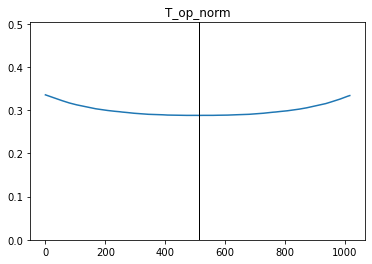

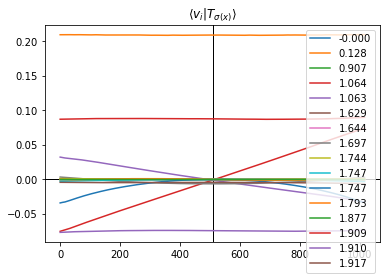

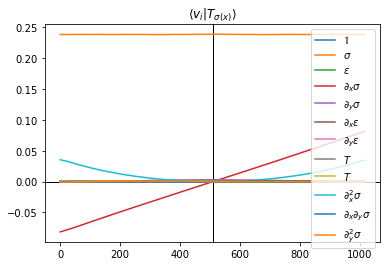

In [19]:
tdu=np.array(data['T_op_dot'].to_list()).T
tn=data['T_op_norm']


plt.plot(data['x'],tn)
plt.axhline(0,color='black',lw=1)
plt.axvline(511.5,color='black',lw=1)
plt.ylim([0,tn.max()*1.5])
plt.title('T_op_norm')
plt.show()

plt.axhline(0,color='black',lw=1)
plt.axvline(511.5,color='black',lw=1)
for i in range(tdu.shape[0]):
    plt.plot(data['x'],tdu[i],label=labels[i])
plt.title(r'$\langle v_i | T_{\sigma(x)} \rangle$')
plt.legend()
plt.show()

plt.axhline(0,color='black',lw=1)
plt.axvline(511.5,color='black',lw=1)
tdurot=_toN(Mrot)@tdu
for i in range(tdurot.shape[0]):
    plt.plot(data['x'],tdurot[i],label=labels1[i])
plt.title(r'$\langle v_i | T_{\sigma(x)} \rangle$')
plt.legend()
plt.show()

it looks pretty ads/cft-ish. if I put a positive charge on a point and a negative charge on another point, except for anticipated $\partial \phi$, the total contribution is not zero on $\phi$, depending on which charge is closer to the boundary

In [136]:
import itertools as itt
importlib.reload(HOTRGZ2)
from HOTRGZ2 import get_isometry_from_layer



def contract_isometries_2D(layers):
    bond_dim=layers[0].tensor_shape[0]
    mapping={(i,j):torch.eye(bond_dim) for i,j in itt.combinations(range(4),2)}
    mappings={0:mapping.copy()}
    for iLayer in range(2,len(layers)+1,2):
        w0=layers[iLayer-1].get_isometry(2)
        w1=layers[iLayer-1].get_isometry(3)
        w2=layers[iLayer-2].get_isometry(2)
        w3=layers[iLayer-2].get_isometry(3)
        ws=[w0,w1,w2,w3]
        nMapping={}
        for (i,j),mij in mapping.items():
            nMapping[(i,j)]=contract('aij,bIJ,iI,jJ->ab',ws[i],ws[j].conj(),mij,mij)
        mapping=nMapping
        mappings[iLayer]=mapping
    return mappings
                
mappings=contract_isometries_2D(layers)
#for iLayer,mapping in mappings.items():
#    for (i,j),mij in mapping.items():
#        show_matrix(mij,max_dim=6)
#        plt.show()

ImportError: cannot import name 'get_isometry_from_layer' from 'HOTRGZ2' (/home/wenhan/jupyter/SRG/HOTRGZ2.py)

In [54]:
def cylinder_to_square(Tc,mapping):
    return contract('ijkl,jJ,kK,lL',Tc,mapping[(0,1)],mapping[(0,2)],mapping[(0,3)])

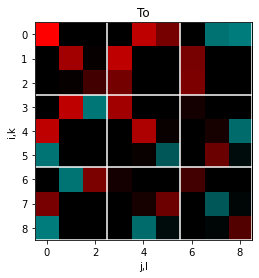

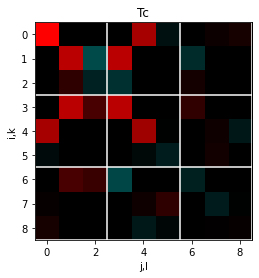

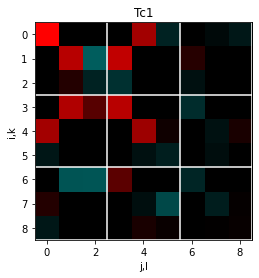

In [60]:
To=Ts[iLayer]
Tr=torch.tensor(ur[:,0]).reshape(T.shape)
Tc=torch.tensor(uc[:,0]).reshape(T.shape)
Tc=cylinder_to_square(Tc,mappings[iLayer])


def cleanup(T,Tref):
    T,_=fix_gauge.minimal_canonical_form(T,eps=0,max_iter=200)
    if(T[0,0,0,0]<0):T=-T
    #T,_=fix_unitary(T,Tref)
    T,dd=fix_gauge.fix_phase(T,Tref)
    T/=T.norm()
    return T

To=cleanup(To,Tref=Ts[iLayer])
Tr=cleanup(Tr,Tref=Ts[iLayer])
Tc=cleanup(Tc,Tref=Ts[iLayer])

def process(T):
    T=T/T.max()
    T=T.sign()*T.abs()**.5
    return T
show_tensor_ikjl(process(To.permute(2,3,0,1)),max_dim=3);plt.title('To');plt.show()
#show_tensor_ikjl(process(Tr),max_dim=3);plt.title('Tr');plt.show()
show_tensor_ikjl(process(Tc),max_dim=3);plt.title('Tc');plt.show()
show_tensor_ikjl(process(Tc1),max_dim=3);plt.title('Tc1');plt.show()

In [ ]:
To=Ts[]

In [574]:
from fix_gauge import contract_all_legs_but_one,apply_matrix_to_leg
from safe_svd import svd

def fix_unitary(T,Tref):
    hh=[]
    for k in range(len(T.shape)//2):
        MM=contract_all_legs_but_one(T,T,2*k)
        MMr=contract_all_legs_but_one(Tref,Tref,2*k)
        u,s,vh=svd(MM)
        ur,sr,vrh=svd(MMr)
        #show_matrix(MM);plt.show()
        #show_matrix(MMr);plt.show()
        #show_matrix(u);plt.show()
        #show_matrix(ur);plt.show()
        h=ur@u.T.conj()
        T=apply_matrix_to_leg(T,h,2*k)
        T=apply_matrix_to_leg(T,h.conj(),2*k+1)
        hh.extend([h,h.conj()])
    return T,hh

Tr-To tensor(0.0441)
Tc-Tr tensor(0.6715)
Tc-To tensor(0.6609)


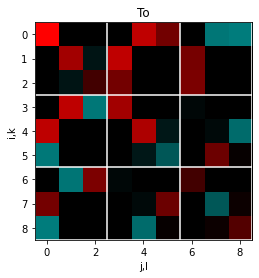

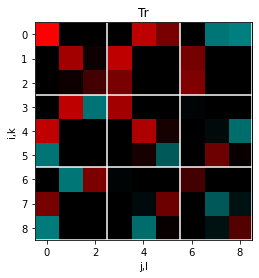

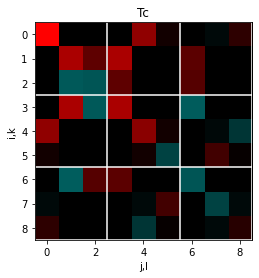

In [577]:

def cleanup(T,Tref):
    T,_=fix_gauge.minimal_canonical_form(T,eps=0,max_iter=200)
    if(T[0,0,0,0]<0):T=-T
    T,_=fix_unitary(T,Tref)
    T,dd=fix_gauge.fix_phase(T,Tref)
    T/=T.norm()
    return T

To=cleanup(Ts[iLayer],Tref=Ts[iLayer])
Tr=cleanup(torch.tensor(ur[:,0]).reshape(T.shape),Tref=Ts[iLayer])
Tc=cleanup(torch.tensor(uc[:,0]).reshape(T.shape),Tref=Ts[iLayer])
    
print('Tr-To',(Tr-To).norm())
print('Tc-Tr',(Tc-Tr).norm())
print('Tc-To',(Tc-To).norm())

def process(T):
    T=T/T.max()
    T=T.sign()*T.abs()**.5
    return T
show_tensor_ikjl(process(T),max_dim=3);plt.title('To');plt.show()
show_tensor_ikjl(process(Tr),max_dim=3);plt.title('Tr');plt.show()
show_tensor_ikjl(process(Tc),max_dim=3);plt.title('Tc');plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

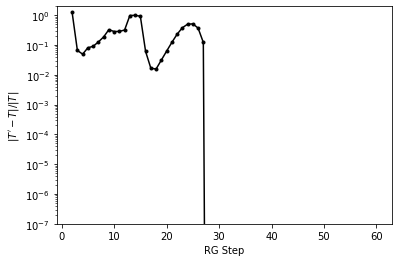

  0%|          | 0/61 [00:00<?, ?it/s]

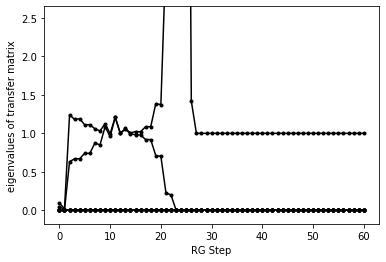

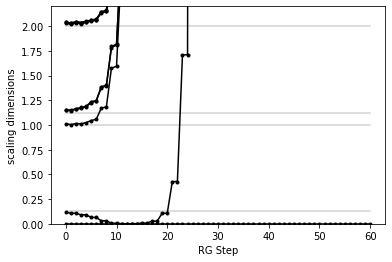

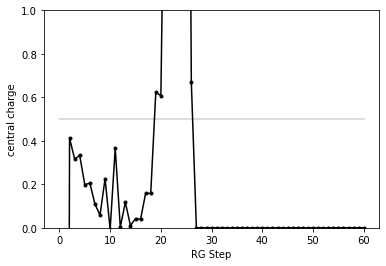

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

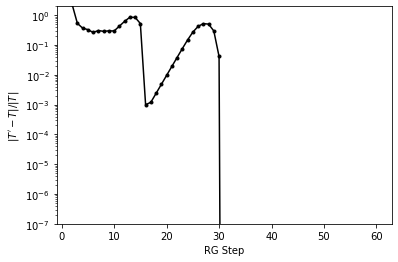

  0%|          | 0/61 [00:00<?, ?it/s]

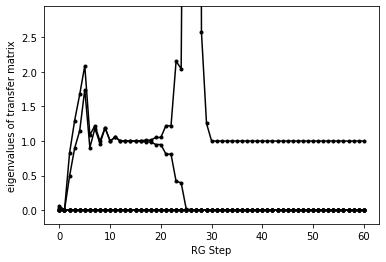

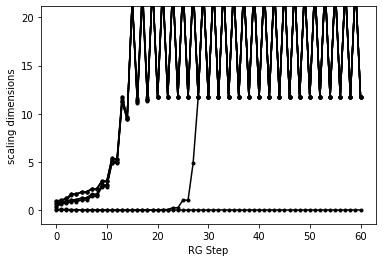

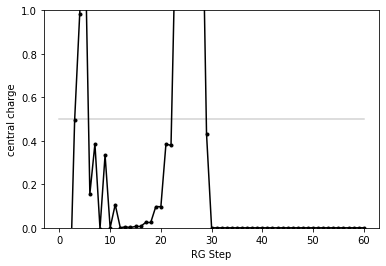

In [570]:

layers1,Ts1,logTotals1=HOTRG_layers(Tr,dimR=None,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
Ts1,layers1=fix_HOTRG_gauges(Ts1,layers1)

show_diff(Ts1,stride=2)
curve=show_scaling_dimensions(Ts1,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)

layers1,Ts1,logTotals1=HOTRG_layers(Tc,dimR=None,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
Ts1,layers1=fix_HOTRG_gauges(Ts1,layers1)

show_diff(Ts1,stride=2)
curve=show_scaling_dimensions(Ts1,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=None,reference_center_charge=reference_center_charge)

In [385]:
T_r=torch.tensor(u[:,0]).reshape(T.shape)

In [386]:
(T_r/T_r.norm()-T/T.norm()).norm()

tensor(0.0456)

In [387]:
def get_linearized_cylinder(T):
    def evolve(v):
        v=v.reshape(T.shape)
        return contract('iIab,jJbc,kKcd,lLda,IJKL->ijkl',T,T,T,T,v).reshape(-1)
    def operator(v):
        return evolve(torch.tensor(v)).detach().cpu().numpy()
    return operator
    

In [ ]:
def get_op():
    dimT=900
    def linearized_operator(x):
        y=np.zeros(x.shape)
        for i,v in enumerate([1,.5,.5,.1,.1]):
            y[i]=v*x[i]
        return y
    return LinearOperator(shape=(dimT,dimT),matvec=linearized_operator)

# https://github.com/brucelyu/tensorRGflow/blob/main/analysisCodes/HOTRG.py
# https://pytorch.org/functorch/nightly/generated/functorch.jvp.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html

In [ ]:

def myeig(M,k=10,tol=1e-7,maxiter=200):
    dim=M.shape[0]
    eigvecs,eigvals=[],[]
    tols=tol if isinstance(tol,list) else [tol]*k
    maxiters=maxiter if isinstance(maxiter,list) else [maxiter]*k
    pbar1=tqdm(range(k),leave=False)
    for j in pbar1:
        v=np.random.randn(dim);v=v/np.linalg.norm(v)
        pbar=tqdm(range(maxiters[j]),leave=False)
        for i in pbar:
            vn=M*v
            for u in eigvecs:
                vn=vn-u*(u@vn)
            eig=np.linalg.norm(vn)/np.linalg.norm(v)
            #print(eig)
            if np.linalg.norm(vn)==0:
                raise ValueError
            vn=vn/np.linalg.norm(vn)
            err=np.linalg.norm(vn-v)
            #pbar.set_postfix(err=err)
            pbar1.set_postfix(eig=eig,err=err)
            if err<=tols[j]:
                pbar.close()
                break
            v=vn
        if err>tols[j]:
            print('Not Converged! err=',err)
        eigvecs.append(v)
        eigvals.append(eig)
    return eigvals,np.array(eigvecs).T